In [1]:
import ray
import numpy as np
import matplotlib.pyplot as plt
from environment import SimpleEnv
from ray_gnn import MPNNModel
from ray import tune, air
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.pre_checks.env import check_env
from ray.rllib.algorithms.ppo import PPOConfig

episode: 0
cumulative reward: -10


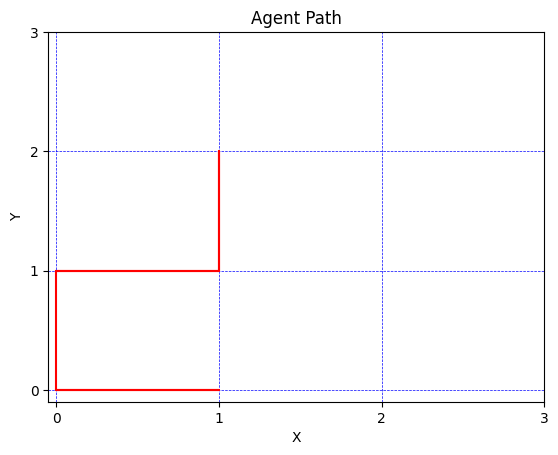

In [8]:
# instantiate the env
length, width, capacity = 4, 4, 2
edge_capacity = np.full((length,width,4),capacity)
nets = [(0,0), (3,2)]
macros = []
env= SimpleEnv(length, width, nets, macros, edge_capacity)
num_episodes = 1

# render the env with random moves
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        total_reward += reward

        if done:
            break

    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [9]:
# register and check the env
register_env("simple_env", lambda config: SimpleEnv(length, width, nets, macros, edge_capacity))

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

# register the custom model
ModelCatalog.register_custom_model("custom_mpnn", MPNNModel)

2023-11-24 10:16:27,159	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


checking environment ...
All checks passed. No errors found.


/home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [10]:
# config everything
config = (
    PPOConfig()
    .environment(env = "simple_env")
    .framework(framework="torch")
    .evaluation(
        evaluation_interval=15, 
        evaluation_duration=5,      
        evaluation_num_workers=2,  #0 for Colab
        evaluation_parallel_to_training=True, #False for Colab
        evaluation_config = dict(
            explore=False,
            num_workers=1
        ))
    .rollouts(
    num_rollout_workers=2, #1 for Colab
    num_envs_per_worker=1)
    .training(
        model={
            "custom_model": "custom_mpnn",
            "custom_model_config": {  # This is the additional configuration for your model
            "node_features_dim": 2,  # Replace with your actual value
            "edge_features_dim": 1,  # Replace with your actual value
            "action_space_dim": 4,  # Replace with your actual value
            # Add other necessary configurations specific to your model
            }
        }#,
        #_enable_learner_api=False
    )
)
#config.rl_module(_enable_rl_module_api=False)
stop_criteria = dict(training_iteration = 20)
tuner = tune.Tuner(
    config.algo_class,
    param_space = config.to_dict(),
    run_config = air.RunConfig(
        local_dir = "/home/brucexi2/UBC-EECE571F/checkpoint/trial",
        stop = stop_criteria,
        verbose = 2,
        checkpoint_config=air.CheckpointConfig(checkpoint_at_end=True)
    )
)
#algo = config.build()

In [11]:
experiment_results = tuner.fit()

2023-11-24 10:18:17,872	INFO worker.py:1538 -- Started a local Ray instance.


(PPO pid=5156) 2023-11-24 10:18:22,223	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(PPO pid=5156) 2023-11-24 10:18:22,739	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=5219) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=5219)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=5219) 2023-11-24 10:18:26,821	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=5218) 2023-11-24 10:18:26,852	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven'

Trial name,agent_timesteps_total,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,timers
PPO_simple_env_d7cbc_00000,80000,"{'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",{},7.69423,{},96,57.3731,-10,520,"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 4.229324848228885, 'cur_kl_coeff': 2.4414062500000005e-05, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 6.952637637046076, 'policy_loss': 0.0055934379347950544, 'vf_loss': 6.947044149521859, 'vf_explained_var': -0.004740860769825597, 'kl': 0.0035619796251779344, 'entropy': 0.6479515232706583, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 18135.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",80000,80000,80000,4000,80000,4000,0,2,0,0,4000,"{'cpu_util_percent': 13.836206896551724, 'ram_util_percent': 65.11228448275862}",{},{},{},"{'mean_raw_obs_processing_ms': 0.2866589867018052, 'mean_inference_ms': 1.6551264803354457, 'mean_action_processing_ms': 0.03931231495673916, 'mean_env_wait_ms': 0.08840358034263282, 'mean_env_render_ms': 0.0}","{'training_iteration_time_ms': 338329.126, 'load_time_ms': 0.339, 'load_throughput': 11815772.942, 'learn_time_ms': 334193.118, 'learn_throughput': 11.969, 'synch_weights_time_ms': 1.409}"


(RolloutWorker pid=5219) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=5219)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=5218) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=5218)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=5219) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=5219)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=5218) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=5218)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=5219) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/bo

In [12]:
ckpt = "/home/brucexi2/UBC-EECE571F/checkpoint/trial/PPO_2023-11-24_10-18-08/PPO_simple_env_d7cbc_00000_0_2023-11-24_10-18-18/checkpoint_000020"
algo = config.build()
algo.restore(ckpt)

2023-11-24 12:24:47,102	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=11991) 2023-11-24 12:24:50,975	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=11991) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=11991)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=11991) 2023-11-24 12:24:50,984	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=11992) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.p

(RolloutWorker pid=27580) /home/brucexi2/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:230: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=27580)   gym.logger.warn("Casting input x to numpy array.")
2023-11-19 18:06:39,556	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!
2023-11-19 18:13:05,647	WARNING ppo.py:558 -- The mean reward returned from the environment is 14.47825 but the vf_clip_param is set to 10.0. Consider increasing it for policy: default_policy to improve value function convergence.
(RolloutWorker pid=27580) /home/brucexi2/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:230: UserWarning: WARN: Casting input x to numpy array. [repeated 2x across cluster]
(RolloutWorker pid=27580)   gym.logger.warn("Casting input x to numpy array.") [repeated 2x across cluster]
(RolloutWorker pid=27581) /home/brucexi2/.local/

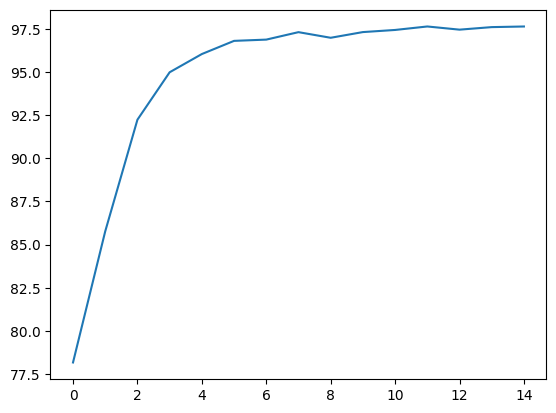

In [ ]:
# train the policy for 10 iterations, also plot the mean reward vs iteration 
rewards = []
for i in range (15):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])
plt.plot(rewards)
plt.show()

1
0
1
1
0
cumulative reward: 96


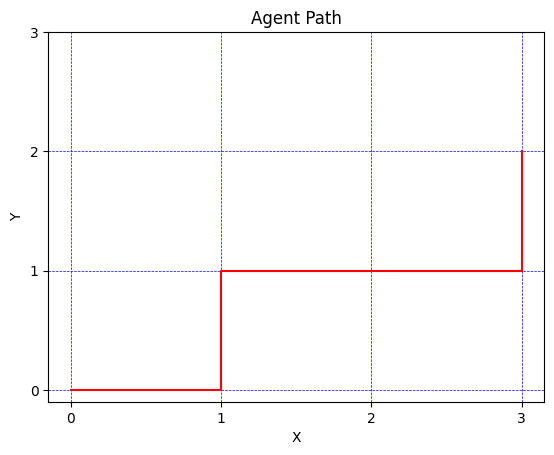

In [93]:
# run inference
num_episodes = 1
env= SimpleEnv(length, width, [(0,0), (3,2)], macros, edge_capacity)
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs)
        print(action)
        obs, reward, done, info = env.step(action)
        #print(obs)
        total_reward += reward
        
        if done:
            break
        
    print(f"cumulative reward: {total_reward}")
    env.render()

In [ ]:
# release the resources
algo.stop()
ray.shutdown()